In [20]:
import pandas as pd
import numpy as np
import os
from PIL import Image # Untuk memproses gambar
from sklearn.model_selection import train_test_split # Untuk membagi dataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Untuk encoding label
import matplotlib.pyplot as plt # Untuk visualisasi (opsional, untuk melihat distribusi kelas)
import seaborn as sns # Untuk visualisasi (opsional, untuk melihat distribusi kelas)

# EDA

In [57]:
# Muat file _annotations.csv ke dalam DataFrame Pandas
try:
    df_anotasi_sampah = pd.read_csv('../data/raw/_annotations.csv')
    print("DataFrame berhasil dimuat.")

except FileNotFoundError:
    print("Error: File '_annotations.csv' tidak ditemukan. Pastikan file berada di direktori yang sama dengan skrip.")
    exit()

DataFrame berhasil dimuat.


In [58]:
# Tampilkan beberapa baris pertama dari DataFrame
df_anotasi_sampah.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,kertas-8-_jpg.rf.ebd50040abe12404cb3e939b7ad6f...,600,600,Organik,179,139,443,380
1,kaleng-27-_jpg.rf.ecbb12b1b9a57e67688f91c55170...,600,600,Anorganik,96,143,589,516
2,kertas-46-_jpg.rf.ed4656c34a961fa0c27c414c899f...,600,600,Organik,134,134,437,521
3,kaleng-31-_jpg.rf.eb634e0aecc6d22618265923f95f...,600,600,Anorganik,115,98,517,518
4,bungkus_makanan-6-_jpg.rf.f053780da1bce1794895...,600,600,Anorganik,170,195,397,455


In [59]:
# Gambaran umum dari DataFrame
df_anotasi_sampah.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1179 entries, 0 to 1178
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1179 non-null   object
 1   width     1179 non-null   int64 
 2   height    1179 non-null   int64 
 3   class     1179 non-null   object
 4   xmin      1179 non-null   int64 
 5   ymin      1179 non-null   int64 
 6   xmax      1179 non-null   int64 
 7   ymax      1179 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 73.8+ KB


# Struktur Dataset Gambar dan Lokasi

In [24]:
image_base_path = '../data/raw/'

# Coba verifikasi keberadaan salah satu gambar
if not df_anotasi_sampah.empty:
    sample_image_filename = df_anotasi_sampah['filename'].iloc[0]
    sample_image_path = os.path.join(image_base_path, sample_image_filename)

    print(f"\nMencoba memverifikasi keberadaan gambar pertama: {sample_image_path}")
    if os.path.exists(sample_image_path):
        print("Jalur gambar pertama ditemukan.")

        # Untuk demonstrasi, kita tidak akan benar-benar membuka gambar di sini,
        # tetapi secara konseptual, Anda akan menggunakan pustaka seperti PIL/Pillow atau OpenCV
        # untuk membuka gambar:
        from PIL import Image
        
        try:
            img = Image.open(sample_image_path)
            print(f"Gambar '{sample_image_filename}' berhasil dibuka (secara konseptual).")
        
        except Exception as e:
            print(f"Gagal membuka gambar '{sample_image_filename}': {e}")
    
    else:
        print(f"Peringatan: Gambar '{sample_image_filename}' tidak ditemukan di jalur yang diharapkan: {sample_image_path}")
        print("Pastikan jalur '../data/raw/' sudah benar dan berisi gambar-gambar Anda.")

else:
    print("\nDataFrame kosong, tidak dapat memverifikasi jalur gambar.")


Mencoba memverifikasi keberadaan gambar pertama: ../data/raw/kertas-8-_jpg.rf.ebd50040abe12404cb3e939b7ad6f685.jpg
Jalur gambar pertama ditemukan.
Gambar 'kertas-8-_jpg.rf.ebd50040abe12404cb3e939b7ad6f685.jpg' berhasil dibuka (secara konseptual).


# Distribusi Kelas Sampah

In [61]:
# Lakukan analisis distribusi kelas sampah
print("\nDistribusi kelas sampah:")
df_anotasi_sampah['class'].value_counts()


Distribusi kelas sampah:


class
Anorganik    597
Organik      582
Name: count, dtype: int64

In [62]:
# Periksa persentase distribusi kelas (opsional, untuk melihat ketidakseimbangan lebih jelas)
print("\nPersentase distribusi kelas sampah:")
df_anotasi_sampah['class'].value_counts(normalize=True) * 100


Persentase distribusi kelas sampah:


class
Anorganik    50.636132
Organik      49.363868
Name: proportion, dtype: float64

# Pra-pemrosesan

In [27]:
# Tentukan ukuran gambar target untuk model CNN Anda
TARGET_IMAGE_SIZE = (224, 224)

# List untuk menyimpan gambar yang telah diproses dan labelnya
processed_images = []
image_labels_raw = [] # Label mentah sebelum encoding
skipped_images_info = [] # Untuk menyimpan info gambar yang dilewati

In [28]:
print(f"\nMemulai pra-pemrosesan gambar dengan ukuran target {TARGET_IMAGE_SIZE}...")

# Iterasi melalui setiap baris di DataFrame untuk memproses gambar
for index, row in df_anotasi_sampah.iterrows():
    filename = row['filename']
    class_label = row['class']
    full_image_path = os.path.join(image_base_path, filename)
    
    try:
        # Membaca gambar
        img = Image.open(full_image_path).convert('RGB') # Pastikan gambar dalam format RGB
        
        # Standardisasi ukuran gambar (resizing)
        img = img.resize(TARGET_IMAGE_SIZE, Image.Resampling.LANCZOS)
        
        # Konversi gambar ke array NumPy
        img_array = np.array(img)
        
        # Normalisasi nilai piksel ke rentang 0-1
        img_array = img_array / 255.0
        
        processed_images.append(img_array)
        image_labels_raw.append(class_label)
        
    except FileNotFoundError:
        skipped_images_info.append(f"Gambar tidak ditemukan: {full_image_path}")
    except Exception as e:
        skipped_images_info.append(f"Terjadi kesalahan saat memproses gambar {full_image_path}: {e}")

print(f"\nSelesai pra-pemrosesan. Jumlah gambar yang berhasil diproses: {len(processed_images)}")
if skipped_images_info:
    print(f"Jumlah gambar yang dilewati karena tidak ditemukan atau error: {len(skipped_images_info)}")
    print("Detail gambar yang dilewati:")
    for info in skipped_images_info:
        print(f"- {info}")


Memulai pra-pemrosesan gambar dengan ukuran target (224, 224)...

Selesai pra-pemrosesan. Jumlah gambar yang berhasil diproses: 1179


In [29]:
# Konversi list gambar yang telah diproses menjadi array NumPy tunggal
X = np.array(processed_images)
print(f"\nBentuk total array gambar (X) setelah pra-pemrosesan: {X.shape}")
print(f"Tipe data array gambar setelah pra-pemrosesan: {X.dtype}")
if X.size > 0: # Cek apakah ada gambar yang berhasil diproses sebelum mengakses min/max
    print(f"Nilai piksel min/max pada gambar pertama setelah normalisasi: {X[0].min()} / {X[0].max()}")



Bentuk total array gambar (X) setelah pra-pemrosesan: (1179, 224, 224, 3)
Tipe data array gambar setelah pra-pemrosesan: float64
Nilai piksel min/max pada gambar pertama setelah normalisasi: 0.0 / 0.9803921568627451


In [30]:
print("\nDistribusi kelas sampah (mentah):")
raw_class_distribution = pd.Series(image_labels_raw).value_counts()
print(raw_class_distribution)

plt.figure(figsize=(5, 6))
sns.barplot(x=raw_class_distribution.index, y=raw_class_distribution.values)
plt.title('Distribusi Kelas Sampah (Mentah)')
plt.xlabel('Kelas Sampah')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Distribusi kelas sampah (mentah):
Anorganik    597
Organik      582
Name: count, dtype: int64


# One Hot Encoding

In [31]:
# Konversi label mentah menjadi array NumPy
y_raw = np.array(image_labels_raw)

# Menggunakan LabelEncoder untuk mengubah label string menjadi angka integer
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_raw)
print(f"\nLabel setelah Label Encoding: {integer_encoded[:5]}...") # Tampilkan 5 pertama
print(f"Kelas yang ditemukan oleh LabelEncoder: {label_encoder.classes_}")


Label setelah Label Encoding: [1 0 1 0 0]...
Kelas yang ditemukan oleh LabelEncoder: ['Anorganik' 'Organik']


In [32]:
# Menggunakan OneHotEncoder untuk mengubah label integer menjadi format one-hot
# Reshape diperlukan karena OneHotEncoder mengharapkan input 2D
onehot_encoder = OneHotEncoder(sparse_output=False) # sparse_output=False agar hasilnya dense array
integer_encoded_reshaped = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded_reshaped)

print(f"\nLabel setelah One-Hot Encoding (5 sampel pertama):\n{y[:5]}")
print(f"Bentuk array label (y) setelah One-Hot Encoding: {y.shape}")
print(f"Mapping kelas ke One-Hot: {onehot_encoder.get_feature_names_out(input_features=['class_label'])}")


Label setelah One-Hot Encoding (5 sampel pertama):
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Bentuk array label (y) setelah One-Hot Encoding: (1179, 2)
Mapping kelas ke One-Hot: ['class_label_0' 'class_label_1']


In [33]:
# Verifikasi: Pastikan jumlah sampel X dan y sama
print(f"\nJumlah sampel X (gambar): {X.shape[0]}")
print(f"Jumlah sampel y (label): {y.shape[0]}")

if X.shape[0] != y.shape[0]:
    print("Peringatan: Jumlah sampel gambar dan label tidak cocok!")


Jumlah sampel X (gambar): 1179
Jumlah sampel y (label): 1179


# Membagi Data (Training, Validation, Test Set)

In [34]:
# Bagi data menjadi training (80%) dan temporary (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Bagi data temporary menjadi validation (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nBentuk X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Bentuk X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Bentuk X_test: {X_test.shape}, y_test: {y_test.shape}")

# Periksa distribusi kelas di setiap set untuk memastikan stratifikasi berhasil
print("\nDistribusi kelas di Training Set:")
print(pd.Series(label_encoder.inverse_transform(np.argmax(y_train, axis=1))).value_counts(normalize=True) * 100)

print("\nDistribusi kelas di Validation Set:")
print(pd.Series(label_encoder.inverse_transform(np.argmax(y_val, axis=1))).value_counts(normalize=True) * 100)

print("\nDistribusi kelas di Test Set:")
print(pd.Series(label_encoder.inverse_transform(np.argmax(y_test, axis=1))).value_counts(normalize=True) * 100)


Bentuk X_train: (943, 224, 224, 3), y_train: (943, 2)
Bentuk X_val: (118, 224, 224, 3), y_val: (118, 2)
Bentuk X_test: (118, 224, 224, 3), y_test: (118, 2)

Distribusi kelas di Training Set:
Anorganik    50.583245
Organik      49.416755
Name: proportion, dtype: float64

Distribusi kelas di Validation Set:
Anorganik    50.847458
Organik      49.152542
Name: proportion, dtype: float64

Distribusi kelas di Test Set:
Anorganik    50.847458
Organik      49.152542
Name: proportion, dtype: float64


In [35]:
# Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ImageDataGenerator dengan teknik augmentasi yang diinginkan
# Anda bisa menyesuaikan parameter ini sesuai kebutuhan
datagen = ImageDataGenerator(
    rotation_range=20,        # Rotasi gambar secara acak hingga 20 derajat
    width_shift_range=0.2,    # Geser gambar secara horizontal hingga 20% dari lebar
    height_shift_range=0.2,   # Geser gambar secara vertikal hingga 20% dari tinggi
    shear_range=0.2,          # Geser geser (shear transformation)
    zoom_range=0.2,           # Perbesar atau perkecil gambar secara acak
    horizontal_flip=True,     # Balik gambar secara horizontal secara acak
    fill_mode='nearest'       # Strategi pengisian piksel yang baru dibuat
)

# Contoh penggunaan augmentasi data:
# Biasanya, augmentasi diterapkan selama proses training.
# Anda tidak perlu membuat salinan fisik gambar yang diaugmentasi di disk,
# melainkan datagen akan menghasilkan batch gambar yang diaugmentasi secara on-the-fly.


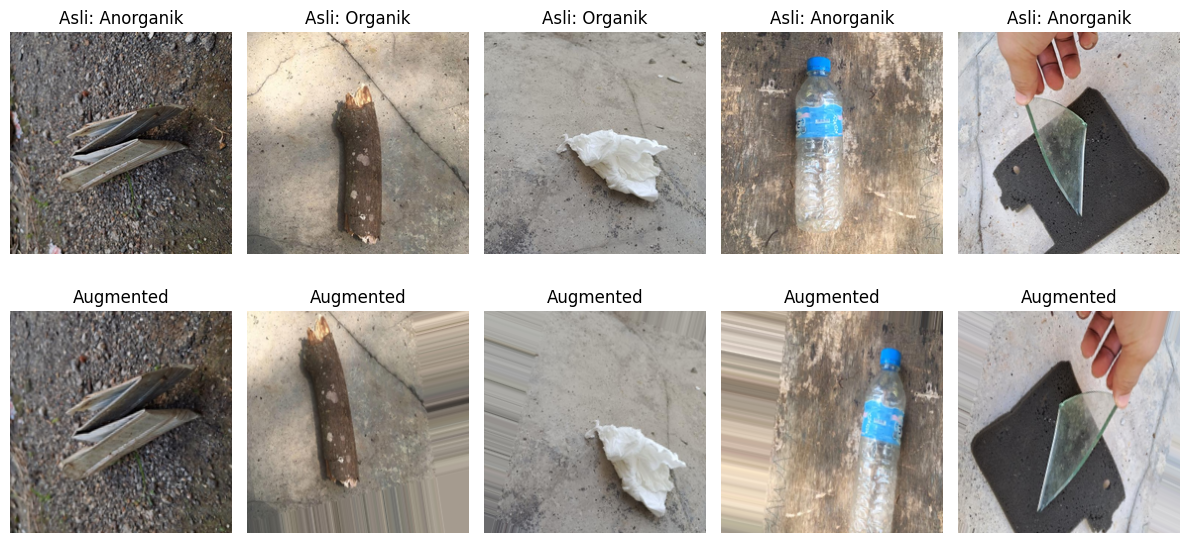

In [36]:
# Ambil beberapa sampel dari X_train untuk demonstrasi
sample_images_for_augmentation_demo = X_train[:5]
sample_labels_for_augmentation_demo = y_train[:5]

plt.figure(figsize=(12, 6))
for i, (original_image, original_label) in enumerate(zip(sample_images_for_augmentation_demo, sample_labels_for_augmentation_demo)):
    # Tampilkan gambar asli
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_image)
    plt.title(f"Asli: {label_encoder.inverse_transform([np.argmax(original_label)])[0]}")
    plt.axis('off')

    # Hasilkan satu gambar yang diaugmentasi dari gambar asli
    # Perlu reshape menjadi (1, height, width, channels) untuk flow
    augmented_image = next(datagen.flow(np.expand_dims(original_image, 0), batch_size=1))[0]
    
    # Tampilkan gambar yang diaugmentasi
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_image)
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Export Dataset Hasil Pre-processing

In [37]:
# --- Konfigurasi Jalur Output ---
output_base_path = '../data/processed/'

# --- Fungsi Pembantu untuk Menyimpan Gambar dan Metadata ---
def save_dataset_split(images, labels, split_name, base_path, label_encoder, onehot_encoder):

    split_path = os.path.join(base_path, split_name)
    os.makedirs(split_path, exist_ok=True) # Buat folder jika belum ada
    
    # List untuk menyimpan metadata gambar yang disimpan di split ini
    metadata_list = []

    print(f"\nMenyimpan dataset '{split_name}' ke: {split_path}...")
    
    # Mendapatkan nama kelas dari onehot_encoder
    class_names = onehot_encoder.get_feature_names_out(input_features=['class_label'])
    
    for i, (img_array, label_onehot) in enumerate(zip(images, labels)):
        # Konversi label one-hot kembali ke nama kelas
        label_index = np.argmax(label_onehot)
        class_name = label_encoder.inverse_transform([label_index])[0]
        
        # Buat nama file baru: "kelas_indeks.jpg"
        # Gunakan f-string untuk penamaan yang rapi dan penomoran unik
        # Contoh: "Organik_0.jpg", "Organik_1.jpg", dst.
        # Untuk memastikan nama unik bahkan jika ada banyak gambar dari kelas yang sama,
        # kita bisa menambahkan indeks global atau hash dari gambar, namun untuk contoh ini
        # kita akan mengandalkan indeks dalam split ini dan jika ada duplikat nama,
        # akan ditimpa (ini bukan masalah jika setiap gambar disimpan sekali per split).
        
        # Untuk nama file yang lebih unik dan menghindari penimpaan jika ada banyak file dengan nama kelas yang sama
        # dan urutan yang sama di split yang berbeda atau duplikasi di satu split:
        # Kita bisa menambahkan hash atau UUID, tapi untuk kesederhanaan, kita gunakan indeks.
        # Jika Anda menemukan penimpaan (misal karena ada gambar "Organik_0.jpg" lain di split yang sama),
        # Anda perlu logika penamaan yang lebih robust (misal, UUID: f"{class_name}_{uuid.uuid4().hex}.jpg")
        
        image_filename = f"{class_name.replace(' ', '_')}_{i:04d}.jpg" # Pad dengan nol untuk 4 digit
        image_save_path = os.path.join(split_path, image_filename)
        
        # Konversi array NumPy (0-1 float) kembali ke 0-255 integer
        img_to_save = Image.fromarray((img_array * 255).astype(np.uint8))
        
        # Simpan gambar
        img_to_save.save(image_save_path)
        
        # Tambahkan metadata untuk CSV
        metadata_list.append({
            'filename': image_filename,
            'class': class_name,
            'width': TARGET_IMAGE_SIZE[0],
            'height': TARGET_IMAGE_SIZE[1],
            # Jika Anda ingin menyimpan bounding box yang asli, Anda perlu menyimpannya dari df asli
            # dan menyesuaikannya jika ukuran gambar diubah secara proporsional.
            # Untuk klasifikasi, bounding box biasanya tidak disimpan lagi setelah gambar dipotong atau di-resize.
        })
        
    # Simpan metadata sebagai CSV di folder split
    metadata_df = pd.DataFrame(metadata_list)
    metadata_df.to_csv(os.path.join(split_path, '_annotations.csv'), index=False)
    print(f"Dataset '{split_name}' berisi {len(metadata_list)} gambar dan metadata berhasil disimpan.")


In [38]:
# Pastikan output_base_path ada
os.makedirs(output_base_path, exist_ok=True)

# Panggil fungsi untuk setiap split
save_dataset_split(X_train, y_train, 'train', output_base_path, label_encoder, onehot_encoder)
save_dataset_split(X_val, y_val, 'val', output_base_path, label_encoder, onehot_encoder)
save_dataset_split(X_test, y_test, 'test', output_base_path, label_encoder, onehot_encoder)



Menyimpan dataset 'train' ke: ../data/processed/train...
Dataset 'train' berisi 943 gambar dan metadata berhasil disimpan.

Menyimpan dataset 'val' ke: ../data/processed/val...
Dataset 'val' berisi 118 gambar dan metadata berhasil disimpan.

Menyimpan dataset 'test' ke: ../data/processed/test...
Dataset 'test' berisi 118 gambar dan metadata berhasil disimpan.
